# Pilot Analyses -- Psifr Edition

## Setup

In [1]:
# %% Dependencies
# import os
# new_dr = "/Users/roberttornatore/Desktop/JATOS/study_assets_root/online_experiments"
# os.chdir(new_dr)
# print(os.getcwd())
from experiments.block_cat.helpers import load_data
from psifr import fr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def get_trial_category_labels(
    category_cues: np.ndarray,
    pres_categoryids: np.ndarray,
) -> list[str]:
    """
    Determine trial category labels ("block", "isolate", "control") based on 
    how many times the cued category appears in the presented categories.

    Args:
        category_cues (np.ndarray): shape [n_trials, 1], category ID cue for each trial
        pres_categoryids (np.ndarray): shape [n_trials, n_items], category ID for each study item

    Returns:
        list[str]: one label per trial
    """
    labels = []
    for cue_cat, pres_cats in zip(category_cues[:, 0], pres_categoryids):
        matches = np.sum(pres_cats == cue_cat)
        if matches == 0:
            label = "control"
        elif matches == 1:
            print(f"Isolate: {cue_cat} {pres_cats}")
            label = "isolate"
        else:
            print(f"Block: {cue_cat} {pres_cats}")
            label = "block"
        labels.append(label)
    return labels

def get_block_success_group(
    target_success: np.ndarray,
    cue_type: list[str],
    recalls: np.ndarray,
) -> list[int]:
    """
    Returns a trial-level feature:
    - 0 if not a successful block-cue targeting trial
    - 1 if first recalled item was studied in position 4-6
    - 2 if first recalled item was studied in position 10-12
    """

    labels = []
    for success, cue, recall_positions in zip(target_success[:, 0], cue_type, recalls):
        if not (success and cue == "block"):
            labels.append(0)
            continue

        first_pos = next((pos for pos in recall_positions if pos > 0), 0)
        if first_pos in [4, 5, 6]:
            labels.append(1)
        elif first_pos in [10, 11, 12]:
            labels.append(2)
        else:
            labels.append(0)

    return labels

def export_to_psifr_long_table(data: dict[str, np.ndarray]) -> pd.DataFrame:
    """Convert data in EMBAM format to long table psifr format.

    Args:
        data (dict[str, np.ndarray]): Data in EMBAM format. In EMBAM format, data is stored
        in a dictionary where each key corresponds to a different variable. The values are
        2-D numpy arrays where each row corresponds to a trial. Required fields in the EMBAM
        format are: 'subject', 'listLength', 'pres_itemnos', 'recalls'. Additional fields
        such as 'condition', 'pres_itemids', and 'rec_itemids' can identify details about
        the trial or each presented or recalled item.

    Returns:
        pd.DataFrame: A pandas DataFrame whose rows correspond to a single study or recall
        event. The required fields in each row are 'subject', 'list', 'trial_type', 'position',
        and 'item'. Additional fields can be included to describe events, e.g., 'condition'.
    """
    events = {
        "subject": [],
        "list": [],
        "trial_type": [],
        "position": [],
        "item": [],
        "condition": [],
        "target_success": [],
        "listLength": [],
        "trial_category_cue": [],
        "category": [],
        "cue_type": [],
        "block_success_group": [],
    }

    # precompute per-trial cue labels to reuse for both study and recall events
    trial_labels = get_trial_category_labels(
        data["category_cues"],
        data["pres_categoryids"],
    )
    block_success_group = get_block_success_group(
        data["target_success"],
        trial_labels,
        data['recalls'],
    )

    # first all study events
    for trial_index, trial in enumerate(data["pres_itemids"]):
        for study_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("study")
            events["position"].append(study_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["pres_categoryids"][trial_index, study_index]
            )
            events["cue_type"].append(trial_labels[trial_index])
            events["block_success_group"].append(block_success_group[trial_index])

    # then all recall events
    for trial_index, trial in enumerate(data["rec_itemids"]):
        for recall_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("recall")
            events["position"].append(recall_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["rec_categoryids"][trial_index, recall_index]
            )
            events["cue_type"].append(trial_labels[trial_index])
            events["block_success_group"].append(block_success_group[trial_index])

    return pd.DataFrame.from_dict(events)


In [3]:
# %% Load data
embam_data_path = "experiments/block_cat/2025_04_10_block_cat.h5"
embam_data = load_data(embam_data_path)
events = export_to_psifr_long_table(embam_data)
events.head()



Block: 26 [18 11  8 26 26 26  5 25  1 26 26 26 31 22 15]
Block: 10 [29 23 28 10 10 10  6  4 32 10 10 10 13  2 24]
Block: 7 [ 5 26 25  7  7  7 17 20 14  7  7  7 27 22  8]
Block: 25 [12 22 30 25 25 25 17 18  1 25 25 25  2  4 26]
Block: 19 [ 9 24 31 19 19 19  6 27  8 19 19 19  5 10 13]
Block: 7 [ 5 13 27  7  7  7 14 19  9  7  7  7 20  6 10]
Isolate: 25 [28 30  4 29 29 29 16 25 11 29 29 29 24  8 23]
Isolate: 19 [32 19  9 12 12 12 27  7 22 12 12 12 15  5 10]
Block: 14 [ 3  6 13 14 14 14 29 18  2 14 14 14 20 16  4]
Isolate: 20 [ 3  7 18 10 10 10  5  8 19 10 10 10 22 20  1]
Block: 25 [ 4 23 32 25 25 25 17 26 13 25 25 25 15 30 28]
Block: 1 [20 15 14  1  1  1 18  2  6  1  1  1 27 11 19]
Isolate: 14 [11 14  9  5  5  5 30 19 22  5  5  5 15  8 16]
Block: 23 [27 20  2 23 23 23 24 21  6 23 23 23 17  4 18]
Block: 16 [25 10 30 16 16 16 14 26  3 16 16 16  5 19 12]
Isolate: 8 [13 20 23 21 21 21  6  8 27 21 21 21  7 24 18]
Block: 14 [ 2 31 11 14 14 14 15 26 12 14 14 14 32 22  9]
Block: 27 [25  8 13 27 27

,subject,list,trial_type,position,item,condition,target_success,listLength,trial_category_cue,category,cue_type,block_success_group
0,0,1,study,1,319,2,True,15,26,18,block,1
1,0,1,study,2,192,2,True,15,26,11,block,1
2,0,1,study,3,130,2,True,15,26,8,block,1
3,0,1,study,4,442,2,True,15,26,26,block,1
4,0,1,study,5,445,2,True,15,26,26,block,1


In [4]:
# %% Merge study and recall events
data = fr.merge_free_recall(
    events,
    list_keys=[
        "condition",
        "target_success",
        "listLength",
        "trial_category_cue",
        "category",
        "cue_type",
        "block_success_group",
    ],
)

data

,subject,list,item,input,output,study,recall,repeat,intrusion,condition,target_success,listLength,trial_category_cue,category,cue_type,block_success_group,prior_list,prior_input
5,0,1,319,1,NaN,True,False,0,False,2,True,15,26,18,block,1,NaN,NaN
3,0,1,192,2,NaN,True,False,0,False,2,True,15,26,11,block,1,NaN,NaN
2,0,1,130,3,NaN,True,False,0,False,2,True,15,26,8,block,1,NaN,NaN
9,0,1,442,4,2.0,True,True,0,False,2,True,15,26,26,block,1,NaN,NaN
10,0,1,445,5,NaN,True,False,0,False,2,True,15,26,26,block,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,19,15,434,12,10.0,True,True,0,False,0,False,15,0,25,control,0,NaN,NaN
4621,19,15,193,13,NaN,True,False,0,False,0,False,15,0,11,control,0,NaN,NaN
4622,19,15,337,14,2.0,True,True,0,False,0,False,15,0,20,control,0,NaN,NaN
4623,19,15,337,14,11.0,False,True,1,False,0,False,15,0,20,control,0,NaN,NaN


## Demo Analyses

### Probability of First and Second Recall

#### Isolates

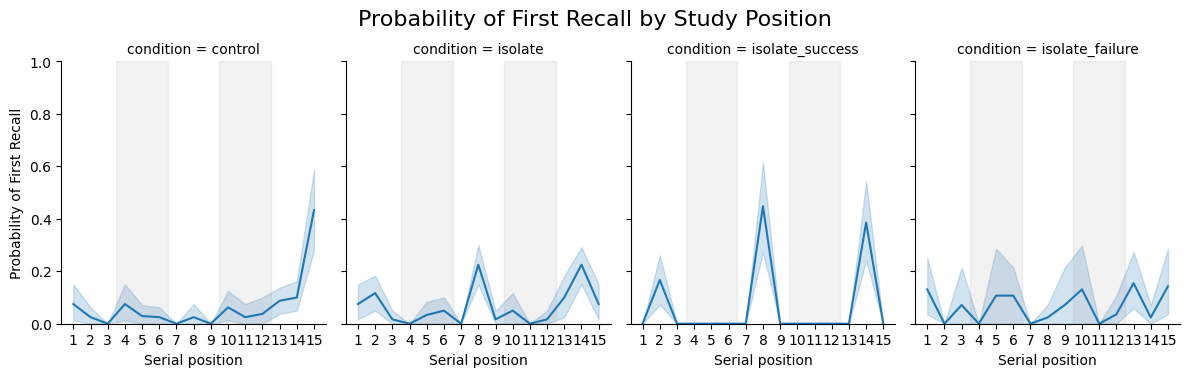

In [5]:
# %% PFR

pnr_control = fr.pnr(data.query('cue_type == "control"'))
# pnr_block = fr.pnr(data.query('cue_type == "block"'))
# pnr_block_success = fr.pnr(data.query('block_success_group > 0'))
# pnr_block1_success = fr.pnr(data.query('block_success_group == 1'))
# pnr_block2_success = fr.pnr(data.query('block_success_group == 2'))
pnr_isolate = fr.pnr(data.query('cue_type == "isolate"'))
pnr_isolate_success = fr.pnr(data.query('cue_type == "isolate" and target_success == 1'))
pnr_isolate_failure = fr.pnr(data.query('cue_type == "isolate" and target_success == 0'))

pnr = pd.concat(
    [
        pnr_control.assign(condition="control"),
        # pnr_block.assign(condition="block"),
        # pnr_block_success.assign(condition="block_success"),
        # pnr_block1_success.assign(condition="block1_success"),
        # pnr_block2_success.assign(condition="block2_success"),
        pnr_isolate.assign(condition="isolate"),
        pnr_isolate_success.assign(condition="isolate_success"),
        pnr_isolate_failure.assign(condition="isolate_failure"),
    ]
)

# Limit to first recall
pfr = pnr.query("output <= 1")

# Plotting
# g = fr.plot_spc(pfr)
# plt.ylim([0, 0.6])
# g = fr.plot_spc(pfr, col="subject", col_wrap=3)
# plt.ylim([0, 0.6])
g = fr.plot_spc(pfr, col="condition", col_wrap=4)
# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)


g.set_ylabels("Probability of First Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of First Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

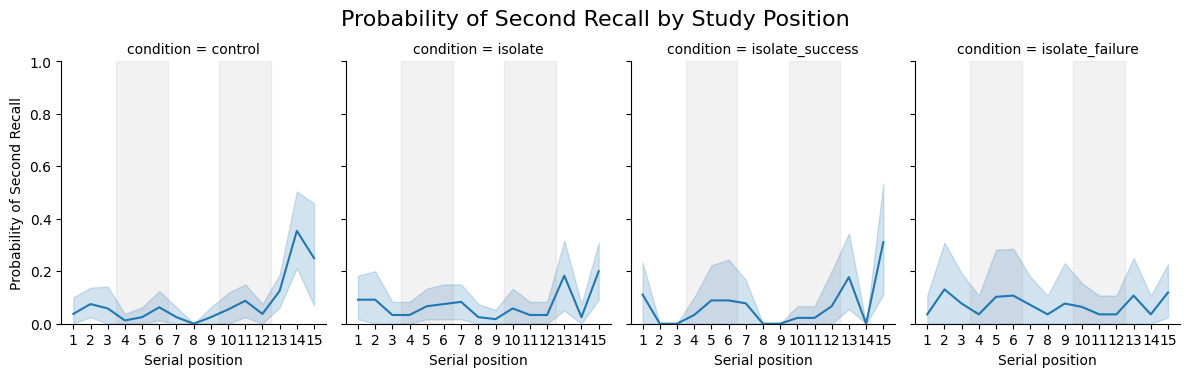

In [6]:
# %% P2R

# Limit to first recall
p2r = pnr.query("output == 2")

# Plotting
# g = fr.plot_spc(p2r)
# plt.ylim([0, 0.7])
# g = fr.plot_spc(p2r, col="subject", col_wrap=5)
# plt.ylim([0, 0.7])
g = fr.plot_spc(p2r, col="condition", col_wrap=4)

# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)

g.set_ylabels("Probability of Second Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of Second Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

#### Block-Cued

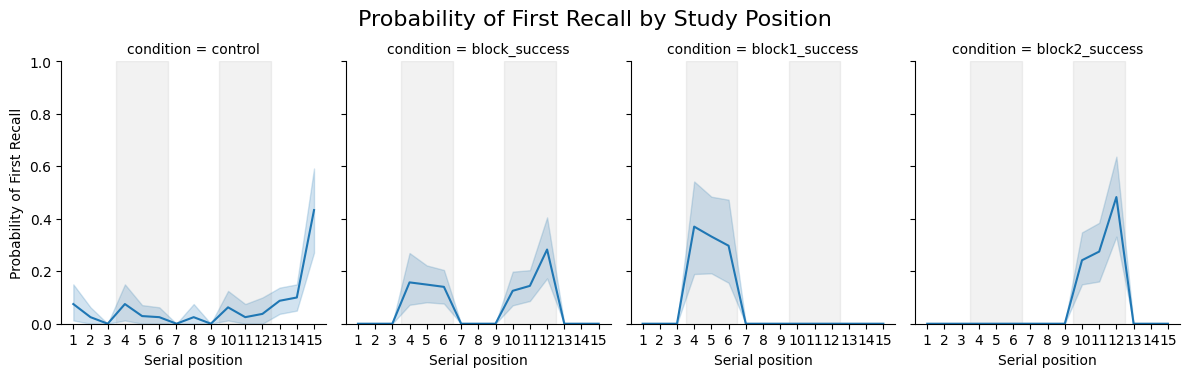

In [7]:
# %% PFR

pnr_control = fr.pnr(data.query('cue_type == "control"'))
# pnr_block = fr.pnr(data.query('cue_type == "block"'))
pnr_block_success = fr.pnr(data.query('block_success_group > 0'))
pnr_block1_success = fr.pnr(data.query('block_success_group == 1'))
pnr_block2_success = fr.pnr(data.query('block_success_group == 2'))
# pnr_isolate = fr.pnr(data.query('cue_type == "isolate"'))
# pnr_isolate_success = fr.pnr(data.query('cue_type == "isolate" and target_success == 1'))
# pnr_isolate_failure = fr.pnr(data.query('cue_type == "isolate" and target_success == 0'))

pnr = pd.concat(
    [
        pnr_control.assign(condition="control"),
        # pnr_block.assign(condition="block"),
        pnr_block_success.assign(condition="block_success"),
        pnr_block1_success.assign(condition="block1_success"),
        pnr_block2_success.assign(condition="block2_success"),
        # pnr_isolate.assign(condition="isolate"),
        # pnr_isolate_success.assign(condition="isolate_success"),
        # pnr_isolate_failure.assign(condition="isolate_failure"),
    ]
)

# Limit to first recall
pfr = pnr.query("output <= 1")

# Plotting
# g = fr.plot_spc(pfr)
# plt.ylim([0, 0.6])
# g = fr.plot_spc(pfr, col="subject", col_wrap=3)
# plt.ylim([0, 0.6])
g = fr.plot_spc(pfr, col="condition", col_wrap=4)
# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)


g.set_ylabels("Probability of First Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of First Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

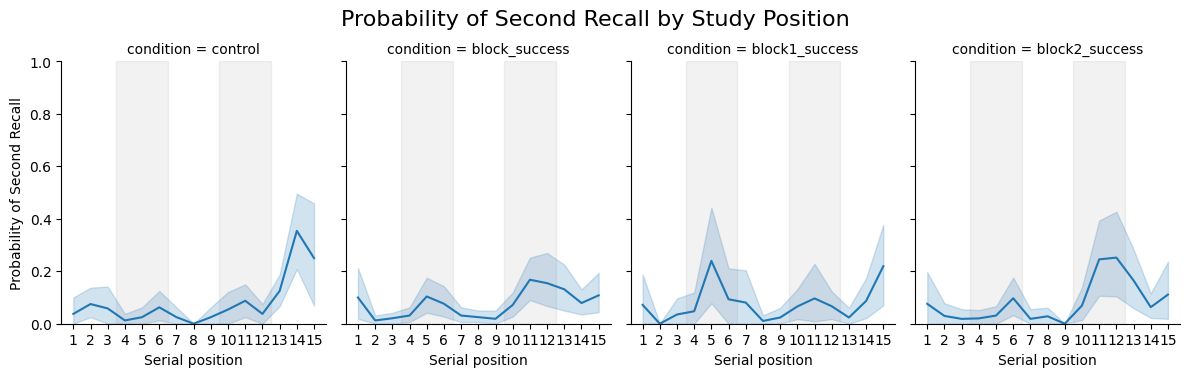

In [8]:
# %% P2R

# Limit to first recall
p2r = pnr.query("output == 2")

# Plotting
# g = fr.plot_spc(p2r)
# plt.ylim([0, 0.7])
# g = fr.plot_spc(p2r, col="subject", col_wrap=5)
# plt.ylim([0, 0.7])
g = fr.plot_spc(p2r, col="condition", col_wrap=4)

# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)

g.set_ylabels("Probability of Second Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of Second Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

### Is overall lag-contiguity disrupted by our category cueing? (Yes)

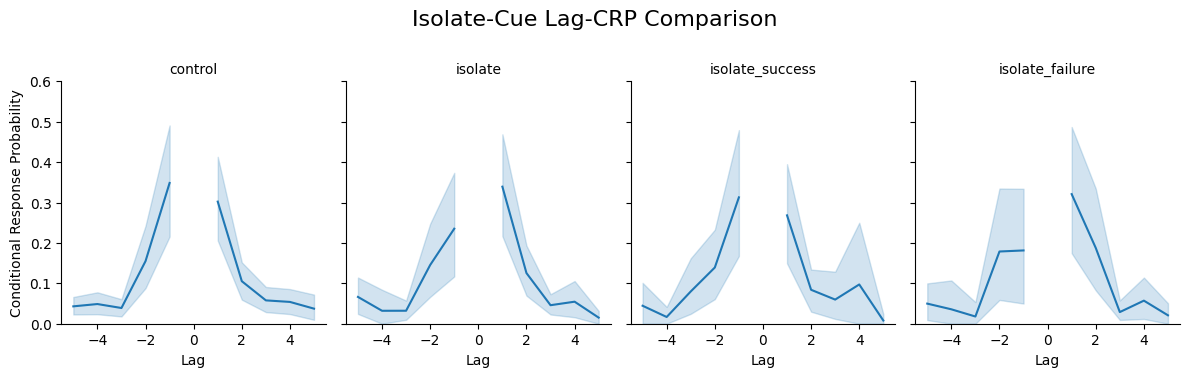

In [9]:
# %% Lag-CRP: Isolates-Focused

# Compute lag-CRP for control and isolate trial types (matching PFR setup)

crp_control = fr.lag_crp(data.query('cue_type == "control"'))

crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'))
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'))
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'))

# Combine with condition labels
lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot: condition-level comparison (main figure)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")

# Add an overall title
g.fig.suptitle("Isolate-Cue Lag-CRP Comparison", fontsize=16)
g.fig.subplots_adjust(top=0.80)

# Optional: subject-level grid
# g = fr.plot_lag_crp(lag_crp, col="subject", col_wrap=5)
# g.fig.set_size_inches(12, 8)
# plt.ylim([0, 0.6])
# g.fig.suptitle("Lag-CRP by Subject", fontsize=16)
# g.fig.subplots_adjust(top=0.9)

# lag_crp

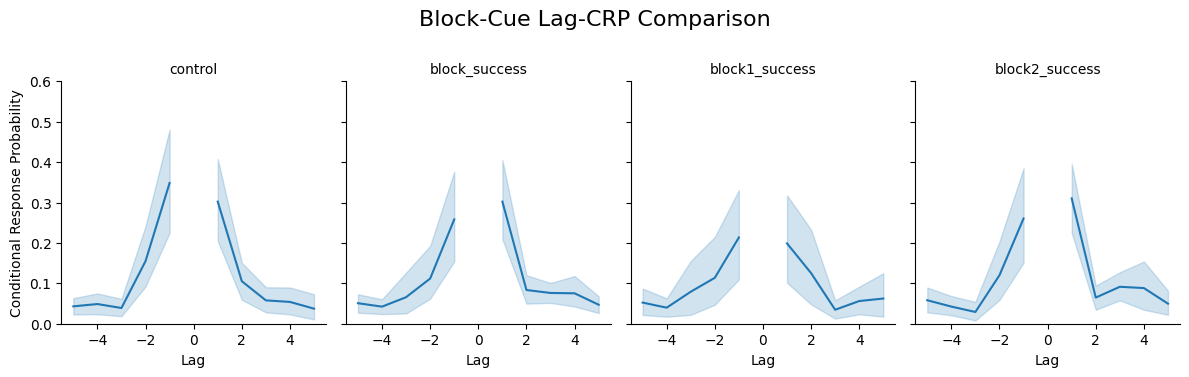

In [10]:
# %% Lag-CRP: Block-Cue Focused

crp_control = fr.lag_crp(data.query('cue_type == "control"'))
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'))
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'))
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'))

# Combine with condition labels
lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])


# Plot: condition-level comparison (main figure)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")

# Add an overall title
g.fig.suptitle("Block-Cue Lag-CRP Comparison", fontsize=16)
g.fig.subplots_adjust(top=0.80)

# Optional: subject-level grid
# g = fr.plot_lag_crp(lag_crp, col="subject", col_wrap=5)
# g.fig.set_size_inches(12, 8)
# plt.ylim([0, 0.6])
# g.fig.suptitle("Lag-CRP by Subject", fontsize=16)
# g.fig.subplots_adjust(top=0.9)

# lag_crp

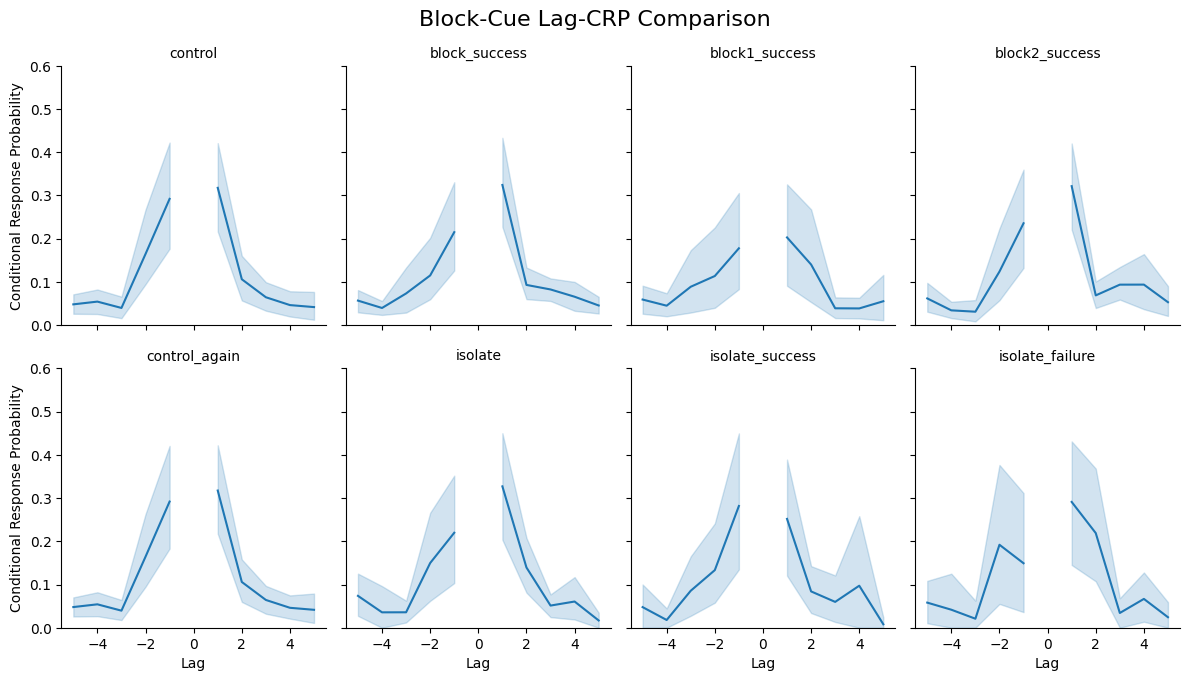

In [11]:
# %% Exclude subjects 0 and 5 to return some forward-assymetry

excluded_subjects = "subject != 0 and subject != 5"

crp_control = fr.lag_crp(data.query(f'cue_type == "control" and {excluded_subjects}'))
crp_block_success = fr.lag_crp(data.query(f'block_success_group > 0 and {excluded_subjects}'))
crp_block1_success = fr.lag_crp(data.query(f'block_success_group == 1 and {excluded_subjects}'))
crp_block2_success = fr.lag_crp(data.query(f'block_success_group == 2 and {excluded_subjects}'))

crp_control_again = fr.lag_crp(data.query(f'cue_type == "control" and {excluded_subjects}'))
crp_isolate = fr.lag_crp(data.query(f'cue_type == "isolate" and {excluded_subjects}'))
crp_isolate_success = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 1 and {excluded_subjects}'))
crp_isolate_failure = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 0 and {excluded_subjects}'))

# Combine with condition labels
lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
    crp_control_again.assign(condition="control_again"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])


# Plot: condition-level comparison (main figure)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 7)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")

# Add an overall title
g.fig.suptitle("Block-Cue Lag-CRP Comparison", fontsize=16)
g.fig.subplots_adjust(top=.9)

# Optional: subject-level grid
# g = fr.plot_lag_crp(lag_crp, col="subject", col_wrap=5)
# g.fig.set_size_inches(12, 8)
# plt.ylim([0, 0.6])
# g.fig.suptitle("Lag-CRP by Subject", fontsize=16)
# g.fig.subplots_adjust(top=0.9)

# lag_crp

In [12]:
# %% Lag-Rank Analysis (isolate-focused)

ranks_control = fr.lag_rank(data.query('cue_type == "control"'))
ranks_isolate = fr.lag_rank(data.query('cue_type == "isolate"'))
ranks_isolate_success = fr.lag_rank(data.query('cue_type == "isolate" and target_success == 1'))
ranks_isolate_failure = fr.lag_rank(data.query('cue_type == "isolate" and target_success == 0'))

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_isolate.assign(condition="isolate"),
        ranks_isolate_success.assign(condition="isolate_success"),
        ranks_isolate_failure.assign(condition="isolate_failure"),
    ]
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("isolate")
print(ranks_isolate.agg(["mean", "sem"])["rank"])
print("isolate_success")
print(ranks_isolate_success.agg(["mean", "sem"])["rank"])
print("isolate_failure")
print(ranks_isolate_failure.agg(["mean", "sem"])["rank"])

ranks

control
mean    0.768319
sem     0.032824
Name: rank, dtype: float64
isolate
mean    0.708177
sem     0.048992
Name: rank, dtype: float64
isolate_success
mean    0.721012
sem     0.045785
Name: rank, dtype: float64
isolate_failure
mean    0.675805
sem     0.068379
Name: rank, dtype: float64


/Users/jordangunn/jatos/study_assets_root/online_experiments/.venv/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/Users/jordangunn/jatos/study_assets_root/online_experiments/.venv/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank,condition
0,0,0.908023,control
1,1,0.867128,control
2,2,0.750130,control
3,3,0.779792,control
4,4,0.989034,control
...,...,...,...
10,13,0.811428,isolate_failure
11,15,0.600808,isolate_failure
12,17,0.974376,isolate_failure
13,18,0.500218,isolate_failure


In [13]:
# %% Lag-Rank Analysis (block-focused)

ranks_control = fr.lag_rank(data.query('cue_type == "control"'))
ranks_block_success = fr.lag_rank(data.query('block_success_group > 0'))
ranks_block1_success = fr.lag_rank(data.query('block_success_group == 1'))
ranks_block2_success = fr.lag_rank(data.query('block_success_group == 2'))

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_block_success.assign(condition="block_success"),
        ranks_block1_success.assign(condition="block1_success"),
        ranks_block2_success.assign(condition="block2_success"),
    ]
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block_success")
print(ranks_block_success.agg(["mean", "sem"])["rank"])
print("block1_success")
print(ranks_block1_success.agg(["mean", "sem"])["rank"])
print("block2_success")
print(ranks_block2_success.agg(["mean", "sem"])["rank"])

ranks

control
mean    0.768319
sem     0.032824
Name: rank, dtype: float64
block_success
mean    0.703938
sem     0.035565
Name: rank, dtype: float64
block1_success
mean    0.639021
sem     0.049736
Name: rank, dtype: float64
block2_success
mean    0.693578
sem     0.039642
Name: rank, dtype: float64


/Users/jordangunn/jatos/study_assets_root/online_experiments/.venv/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank,condition
0,0,0.908023,control
1,1,0.867128,control
2,2,0.750130,control
3,3,0.779792,control
4,4,0.989034,control
...,...,...,...
14,15,0.754658,block2_success
15,16,0.556152,block2_success
16,17,0.986378,block2_success
17,18,0.422273,block2_success


In [14]:
# %% Lag-Rank Analysis (block-focused, excluding subjects 0 and 5)

excluded_subjects = "subject != 0 and subject != 5"

ranks_control = fr.lag_rank(data.query(f'cue_type == "control" and {excluded_subjects}'))
ranks_block_success = fr.lag_rank(data.query(f'block_success_group > 0 and {excluded_subjects}'))
ranks_block1_success = fr.lag_rank(data.query(f'block_success_group == 1 and {excluded_subjects}'))
ranks_block2_success = fr.lag_rank(data.query(f'block_success_group == 2 and {excluded_subjects}'))

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_block_success.assign(condition="block_success"),
        ranks_block1_success.assign(condition="block1_success"),
        ranks_block2_success.assign(condition="block2_success"),
    ]
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block_success")
print(ranks_block_success.agg(["mean", "sem"])["rank"])
print("block1_success")
print(ranks_block1_success.agg(["mean", "sem"])["rank"])
print("block2_success")
print(ranks_block2_success.agg(["mean", "sem"])["rank"])

ranks

control
mean    0.748341
sem     0.033056
Name: rank, dtype: float64
block_success
mean    0.690595
sem     0.038178
Name: rank, dtype: float64
block1_success
mean    0.620334
sem     0.053873
Name: rank, dtype: float64
block2_success
mean    0.682520
sem     0.040378
Name: rank, dtype: float64


,subject,rank,condition
0,1,0.867128,control
1,2,0.750130,control
2,3,0.779792,control
3,4,0.989034,control
4,6,0.726846,control
...,...,...,...
12,15,0.754658,block2_success
13,16,0.556152,block2_success
14,17,0.986378,block2_success
15,18,0.422273,block2_success


## How Often Do Subjects Recall the Category Target?

In [15]:
# %% Focus on targetting trials, then aggregating target_success by subject
success_rates = data.query("condition > 0").pivot_table(
    index="subject", values="target_success", aggfunc="mean"
)

# mean and sem over subjects
print(success_rates.agg(["mean", "sem"])["target_success"])
success_rates

mean    0.718402
sem     0.059045
Name: target_success, dtype: float64


,target_success
subject,
0,0.821429
1,0.454545
2,1.000000
3,0.730994
4,0.727273
5,0.541667
6,0.809524
7,1.000000
8,0.911765


In [16]:
# %% exclude those subjects again
success_rates = data.query(f"condition > 0 and {excluded_subjects}").pivot_table(
    index="subject", values="target_success", aggfunc="mean"
)

# mean and sem over subjects
print(success_rates.agg(["mean", "sem"])["target_success"])
success_rates

mean    0.722497
sem     0.064743
Name: target_success, dtype: float64


,target_success
subject,
1,0.454545
2,1.000000
3,0.730994
4,0.727273
6,0.809524
7,1.000000
8,0.911765
9,0.090361
10,0.449102


## Focusing on Transitions From Category Targets

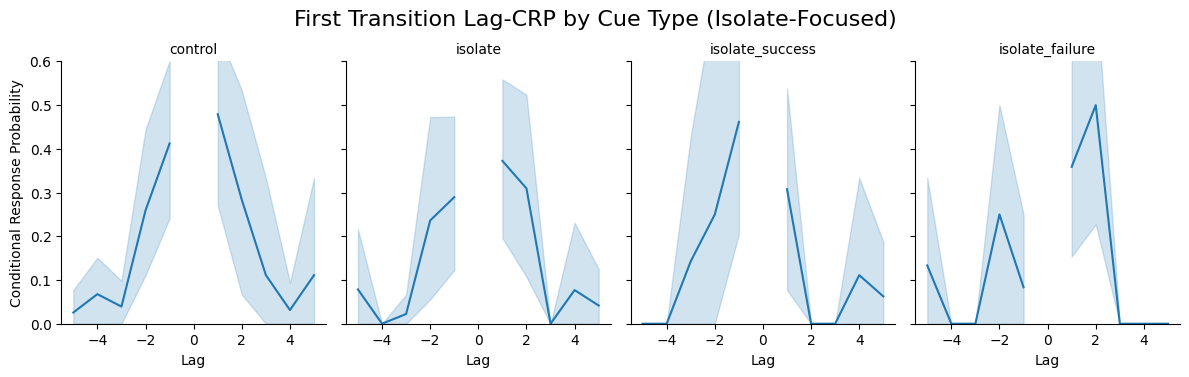

In [17]:
# %% First Transition Lag-CRP (isolate-focused)

item_filter = "output < 3 or not recall"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("First Transition Lag-CRP by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

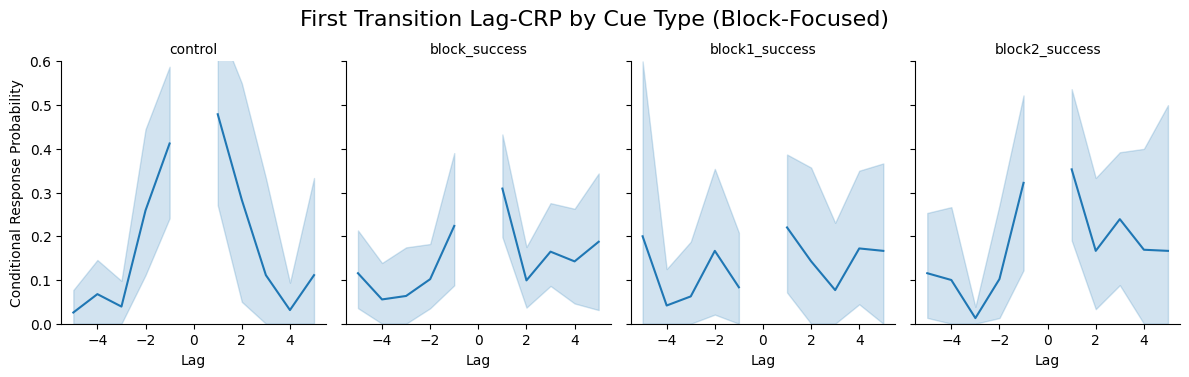

In [18]:
# %% First Transition Lag-CRP (block-focused)

item_filter = "output < 3 or not recall"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'), item_query=item_filter)
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'), item_query=item_filter)
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("First Transition Lag-CRP by Cue Type (Block-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

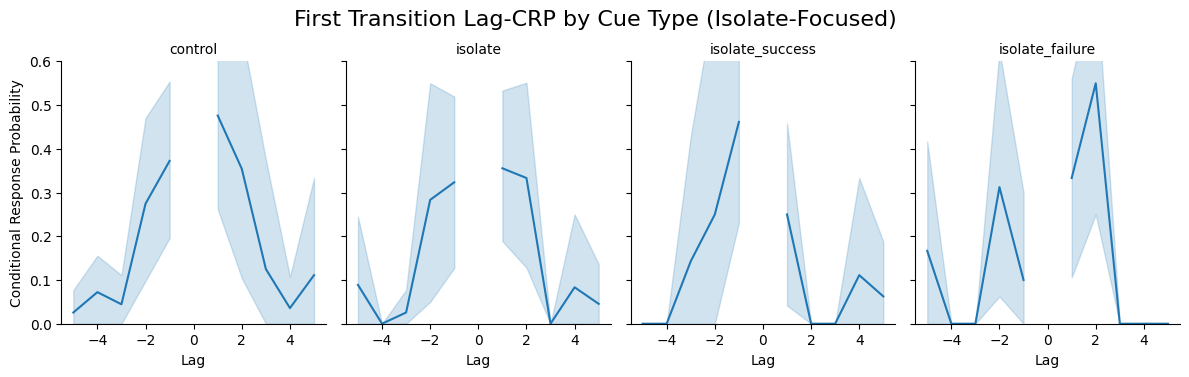

In [19]:
# %% First Transition Lag-CRP (isolate-focused) excluding subjects 0 and 5

item_filter = "output < 3 or not recall"

crp_control = fr.lag_crp(data.query(f'cue_type == "control" and {excluded_subjects}'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query(f'cue_type == "isolate" and {excluded_subjects}'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 1 and {excluded_subjects}'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 0 and {excluded_subjects}'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("First Transition Lag-CRP by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

### Excluding Transitions to First Item

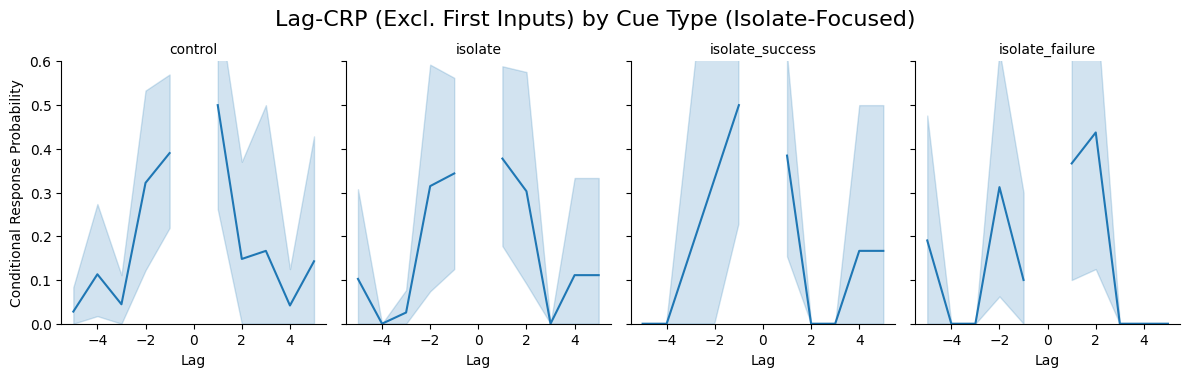

In [20]:
# %% Lag-CRP (exclude transitions to first input items — isolate-focused)

item_filter = "(output < 3 or not recall) and input > 2"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. First Inputs) by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

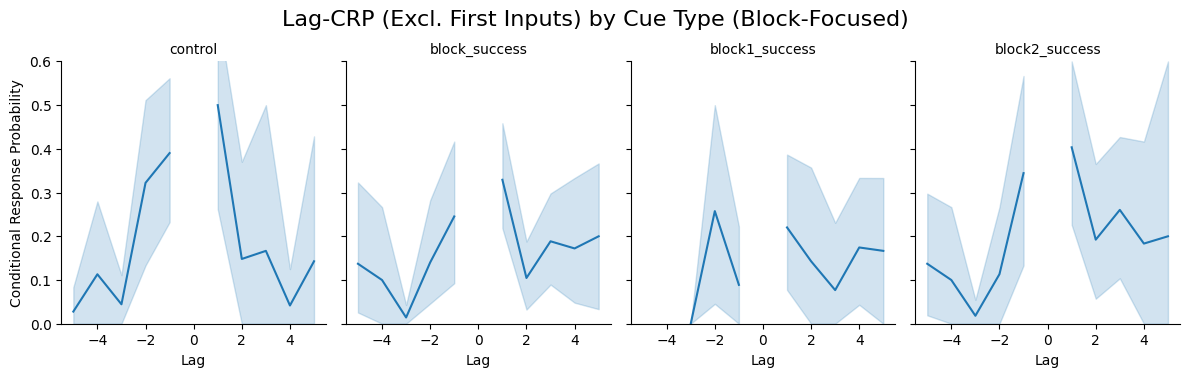

In [21]:
# %% Lag-CRP (exclude transitions to first input items — block-focused)

item_filter = "(output < 3 or not recall) and input > 2"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'), item_query=item_filter)
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'), item_query=item_filter)
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. First Inputs) by Cue Type (Block-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

### Exclude Transitions to Last Item

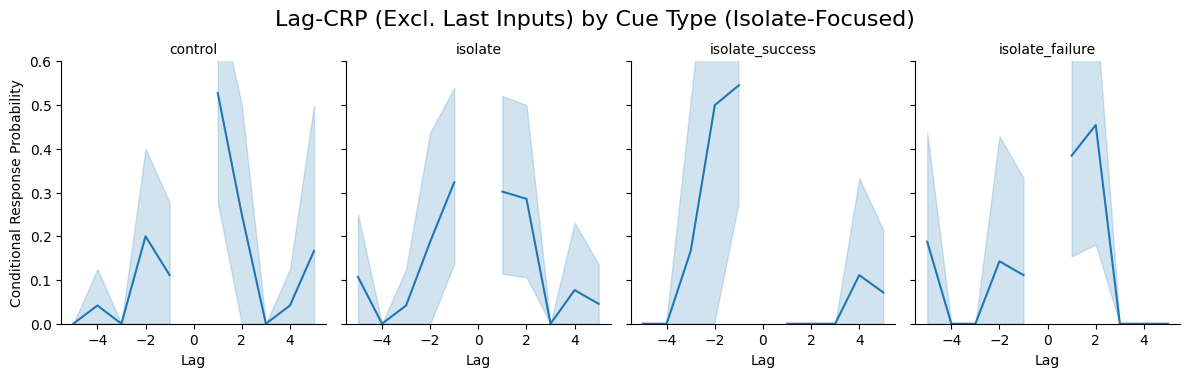

In [22]:
# %% Lag-CRP (exclude transitions to last input items — isolate-focused)

item_filter = "(output < 3 or not recall) and input < 15"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. Last Inputs) by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

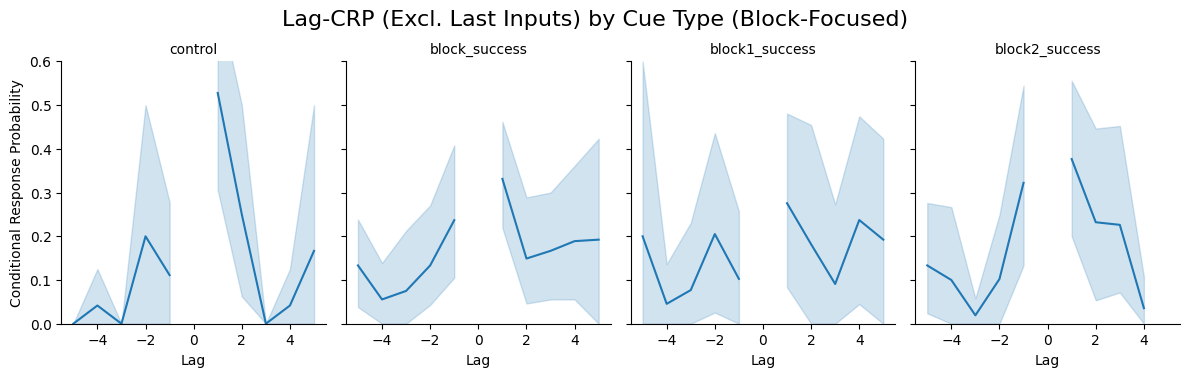

In [23]:
# %% Lag-CRP (exclude transitions to last input items — block-focused)

item_filter = "(output < 3 or not recall) and input < 15"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'), item_query=item_filter)
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'), item_query=item_filter)
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. Last Inputs) by Cue Type (Block-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

## ...

In [24]:
# %% First Transition Lag-Rank

item_filter = "output < 3 or not recall"

ranks_control = fr.lag_rank(
    data.query(f'cue_type == "control"'), item_query=item_filter
)
ranks_block = fr.lag_rank(data.query(f'cue_type == "block"'), item_query=item_filter)
ranks_isolate = fr.lag_rank(
    data.query(f'cue_type == "isolate"'), item_query=item_filter
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block")
print(ranks_block.agg(["mean", "sem"])["rank"])
print("isolate")
print(ranks_isolate.agg(["mean", "sem"])["rank"])

ranks_block
ranks_control
ranks_isolate


control
mean    0.689366
sem     0.061321
Name: rank, dtype: float64
block
mean    0.619418
sem     0.042815
Name: rank, dtype: float64
isolate
mean    0.725713
sem     0.055452
Name: rank, dtype: float64


/Users/jordangunn/jatos/study_assets_root/online_experiments/.venv/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.083333
1,1,0.857576
2,2,0.666667
3,3,0.762963
4,4,0.794372
5,5,0.958333
6,6,0.596296
7,7,1.000000
8,8,0.520833
9,9,0.935897


## Modification: Ignore Transitions to First Item from Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-14,NaN,0,0,control
1,0,-13,0.0,0,2,control
2,0,-12,0.0,0,2,control
3,0,-11,0.0,0,2,control
4,0,-10,0.0,0,2,control
...,...,...,...,...,...,...
459,19,10,NaN,0,0,failure
460,19,11,NaN,0,0,failure
461,19,12,NaN,0,0,failure
462,19,13,NaN,0,0,failure


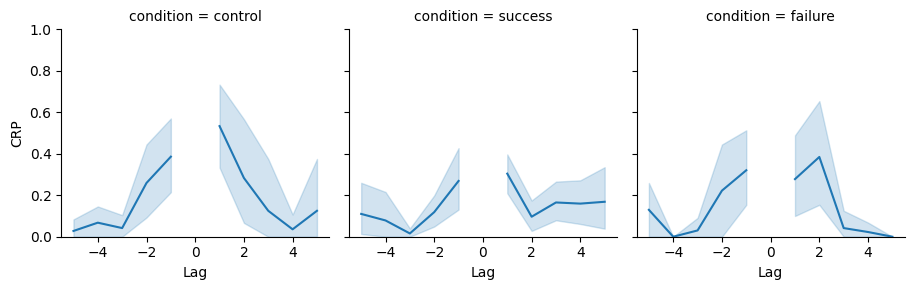

In [25]:
crp_control = fr.lag_crp(
    data.query("condition == 0"),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)
crp_success = fr.lag_crp(
    data.query("condition == 2"),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)
crp_attempt = fr.lag_crp(
    data.query("condition == 1"),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)
lag_crp = pd.concat(
    [
        crp_control.assign(condition="control"),
        crp_success.assign(condition="success"),
        crp_attempt.assign(condition="failure"),
    ]
)

# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=5)
lag_crp

In [26]:
# %% Lag-Rank (first transitions, excluding input 1, grouped by cue_type)

ranks_control = fr.lag_rank(
    data.query('cue_type == "control"'),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)

ranks_block = fr.lag_rank(
    data.query('cue_type == "block"'),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)

ranks_isolate = fr.lag_rank(
    data.query('cue_type == "isolate"'),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_block.assign(condition="block"),
        ranks_isolate.assign(condition="isolate"),
    ]
)

# Print summary stats
print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block")
print(ranks_block.agg(["mean", "sem"])["rank"])
print("isolate")
print(ranks_isolate.agg(["mean", "sem"])["rank"])

ranks_block


control
mean    0.687266
sem     0.059508
Name: rank, dtype: float64
block
mean    0.618709
sem     0.041567
Name: rank, dtype: float64
isolate
mean    0.750441
sem     0.056831
Name: rank, dtype: float64


/Users/jordangunn/jatos/study_assets_root/online_experiments/.venv/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.857388
1,1,0.666592
2,2,0.740476
3,3,0.599107
4,4,0.958409
5,5,0.487143
6,6,0.803571
7,7,0.500000
8,8,0.637311
9,9,0.890000


In [27]:
# Looking at block transitions

block_trials = data.query(
    'cue_type == "block" and target_success == 1 and output <= 2 and recall'
)

# finding the first two outputs in block trials
block_first_two = block_trials[block_trials.output.isin([1, 2])]

# finding the transitions after successfully recalling a block cue
first_transitions = (
    block_first_two.pivot_table(
        index=["subject", "list"], columns="output", values="input"
    )
    .reset_index()
    .rename(columns={1: "first_input", 2: "second_input"})
)


# look at transitions and determine whether it was within its own block, between blocks, or outside of blocks
def classify_transition(first, second):
    block1 = range(4, 7)
    block2 = range(10, 13)
    if first in block1 and second in block1:
        return "within_block1"
    elif first in block2 and second in block2:
        return "within_block2"
    elif first in block1 and second in block2:
        return "between_blocks"
    elif first in block2 and second in block1:
        return "between_blocks"
    elif pd.isna(first) or pd.isna(second):
        return "incomplete"
    else:
        return "outside_block"


first_transitions["transition_type"] = first_transitions.apply(
    lambda row: classify_transition(row["first_input"], row["second_input"]), axis=1
)

In [28]:
pd.pivot_table(data, index=["subject"], columns="output", values="input").values.shape

(20, 17)

In [29]:
first_transitions

output,subject,list,first_input,second_input,transition_type
0,0,1,6.0,4.0,within_block1
1,0,2,5.0,5.0,within_block1
2,0,3,11.0,12.0,within_block2
3,0,5,6.0,11.0,between_blocks
4,0,8,12.0,11.0,within_block2
...,...,...,...,...,...
122,19,4,12.0,11.0,within_block2
123,19,5,12.0,2.0,outside_block
124,19,6,11.0,15.0,outside_block
125,19,12,6.0,10.0,between_blocks


Text(0, 0.5, 'Count')

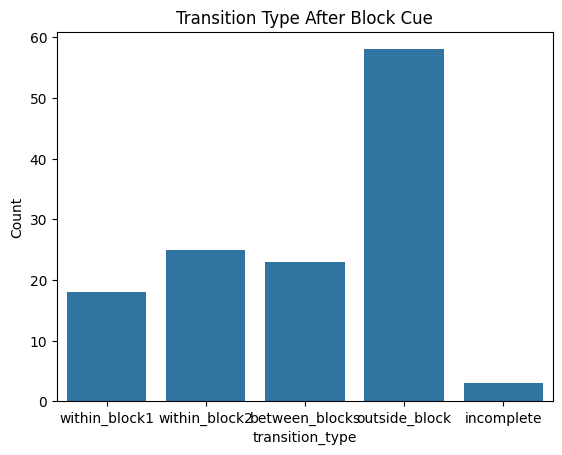

In [30]:
# count up each type of transition
first_transitions["transition_type"].value_counts(normalize=True)

sns.countplot(data=first_transitions, x="transition_type")
plt.title("Transition Type After Block Cue")
plt.ylabel("Count")